In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../')
from dpgo_bag_eval import *
from simulate_utils import *
import numpy as np

def generate_4dof_noise(pg, pos_noise=1.0, rot_noise=0.2):
    print(len(pg.agents))
    agent_offsets = np.random.normal(0, pos_noise*5, (len(pg.agents), 4))
    agent_offsets[:,3] = np.random.normal(0, rot_noise*5, len(pg.agents))
    agent_offsets[0,:] = 0
    for _id in pg.keyframes:
        if _id != 0:
            kf = pg.keyframes[_id]
            agent_offset = agent_offsets[kf.agent_id, :]
            kf.pos = kf.pos + np.random.normal(0, pos_noise, 3) + agent_offset[0:3]
            yaw_noise = np.random.normal(0, rot_noise)
            quat_noise = quaternion_from_euler(0, 0, yaw_noise)
            kf.quat = quaternion_multiply(kf.quat, quat_noise)
        

def generate_data(data_file, data_folder, agent_num, partition="id", show=False, is_4dof=True):
    pg = PoseGraph()
    pg.read_g2o_single(data_file)
    pg_gt = generate_groundtruth_sesync(pg, "/tmp/sesync_gt")
    pg_noise = copy.deepcopy(pg_gt)
    if is_4dof:
        pg_noise.convert_to_4dof()
        pg_gt.convert_to_4dof()
    partitioning(pg_noise, "vol", agent_num=agent_num, show=False, method=partition)
    generate_4dof_noise(pg_noise)
    pg_noise.update_edges()
    pg_noise.write_to_g2o_folder(f"{data_folder}/", cvt_id=True)
    pg_gt.write_to_g2o(f"{data_folder}/groundtruth.g2o")
    if show:
        pg.show("raw")
        pg_gt.show("GT")
        pg_noise.show("noise")



Wrote 6275 edges total 6275
New partion obj -1 agents 5 keyframes 167<->498 inter edges 3246 comm_vol 1673
5
Wrote 9521 edges total 6275


../pose_graph_partitioning/pose_graph.py:728: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return poses, np.array(axes_x),np.array(axes_y),np.array(axes_z), kf_mc, np.array(edges_a), np.array(edges_b)-np.array(edges_a), np.array(edge_real), line_color


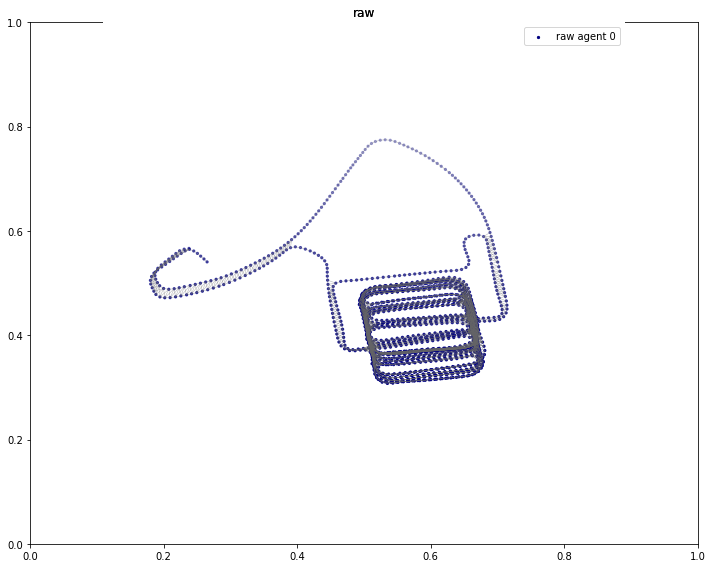

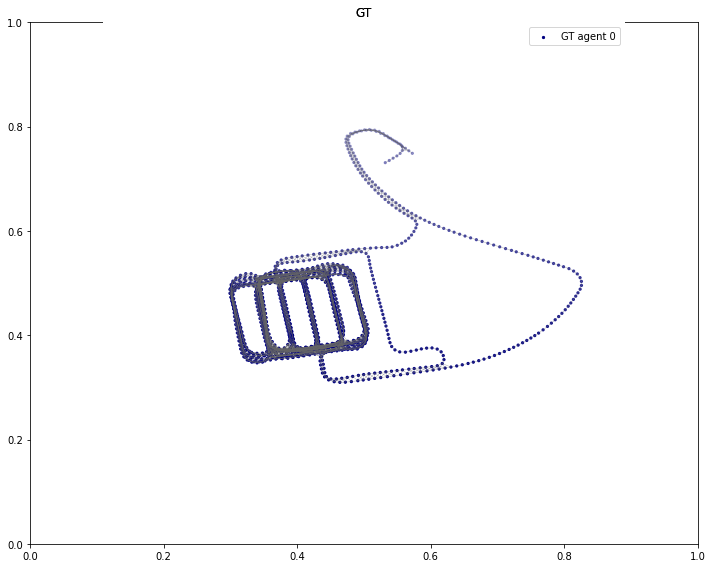

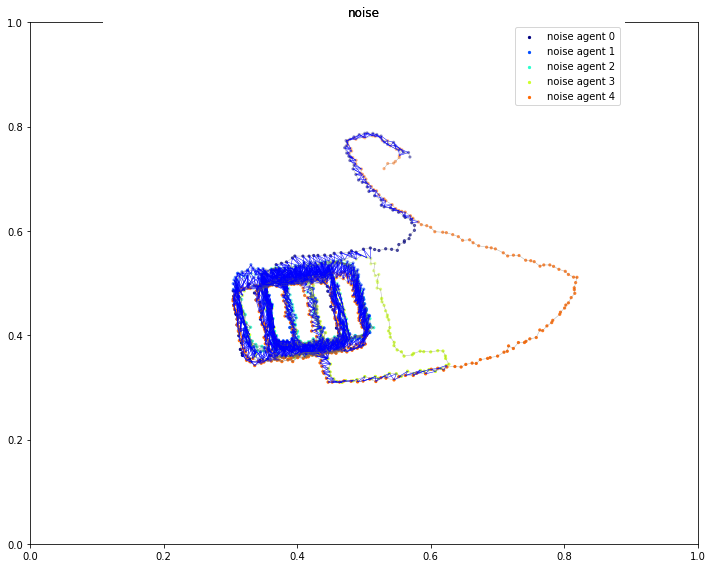

In [3]:
input_data = "/home/xuhao/data/ral2021/raw/parking-garage.g2o"
output_folder = "/home/xuhao/data/d2slam/pgo/parking-garage"
generate_data(input_data, output_folder, 5, partition="id", show=True)